<a href="https://colab.research.google.com/github/bmontoyag/UTEC_IA_Fundamentals/blob/main/Proyecto_final/Experimento_3_2_Modelo_Complejo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalar la biblioteca KaggleHub para interactuar con Kaggle
!pip install -q kagglehub

# Importar las bibliotecas necesarias para la gestión de archivos
import kagglehub
import os

# Descargar el dataset. 'data_dir' contendrá la ruta a la carpeta raíz descargada.
print("Descargando el dataset desde KaggleHub...")
data_dir = kagglehub.dataset_download("muhammadardiputra/potato-leaf-disease-dataset")
print(f"Dataset descargado en: {data_dir}")

# Verificamos el contenido para asegurarnos de la estructura de carpetas
# Esto nos ayuda a construir la ruta completa y correcta en el siguiente paso
print("Contenido de la carpeta descargada:", os.listdir(data_dir))

Descargando el dataset desde KaggleHub...
Dataset descargado en: /kaggle/input/potato-leaf-disease-dataset
Contenido de la carpeta descargada: ['Potato']


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# --- Parámetros para el procesamiento y entrenamiento ---
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 15

# --- Construir la ruta completa al directorio que contiene Train/Test ---
# Basado en la inspección anterior, añadimos el nombre de la subcarpeta
data_dir_full = os.path.join(data_dir, "Potato")

# --- Cargar los datos de entrenamiento y validación (80/20) ---
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir_full, "Train"),
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="both",
    seed=123
)
train_dataset, validation_dataset = dataset

# --- Cargar los datos de prueba ---
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir_full, "Test"),
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Guardar los nombres de las clases (enfermedades)
class_names = train_dataset.class_names
print("\nClases detectadas:", class_names)

# --- Optimización del rendimiento del dataset ---
# Normaliza los valores de los píxeles al rango [0, 1] y usa caché para acelerar la carga
def normalize(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

train_dataset = train_dataset.map(normalize).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(normalize).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(normalize).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("\n¡Datos listos para el entrenamiento!")

Found 900 files belonging to 3 classes.
Using 720 files for training.
Using 180 files for validation.
Found 300 files belonging to 3 classes.

Clases detectadas: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

¡Datos listos para el entrenamiento!


In [ ]:
# Capa para aplicar transformaciones aleatorias a las imágenes y evitar sobreajuste
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# --- Construcción de la Arquitectura del Modelo CNN ---
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
num_classes = len(class_names)

# Versión más compleja (filtros adicionales)
model_complejo = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    data_augmentation,
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'), # Más filtros
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'), # Más filtros
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'), # Más filtros
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'), # Capa densa más grande
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# --- Compilar el modelo con un optimizador, función de pérdida y métricas ---
model_complejo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Muestra un resumen de la arquitectura del modelo
model_complejo.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    67,109,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,480,707 (257.42 MB)

 Trainable params: 67,480,707 (257.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\nIniciando el entrenamiento del modelo...")

history = model_complejo.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_dataset,
    verbose=1,
)

print("\n Entrenamiento completado.")


Iniciando el entrenamiento del modelo...
Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 361s 15s/step - accuracy: 0.3635 - loss: 3.0583 - val_accuracy: 0.4833 - val_loss: 0.9483
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 361s 16s/step - accuracy: 0.5931 - loss: 0.8594 - val_accuracy: 0.7611 - val_loss: 0.5038
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 355s 15s/step - accuracy: 0.8675 - loss: 0.3951 - val_accuracy: 0.8278 - val_loss: 0.4949
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 391s 16s/step - accuracy: 0.8699 - loss: 0.3453 - val_accuracy: 0.8778 - val_loss: 0.3569
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 386s 16s/step - accuracy: 0.8369 - loss: 0.3884 - val_accuracy: 0.7500 - val_loss: 1.4494
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 372s 16s/step - accuracy: 0.8965 - loss: 0.2702 - val_accuracy: 0.9000 - val_loss: 0.2792
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 364s 16s/step - accuracy: 0.8976 - loss: 0.2716 - val_accuracy: 0.9278 - val_loss: 0.2127
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 355s 15s/step - accuracy

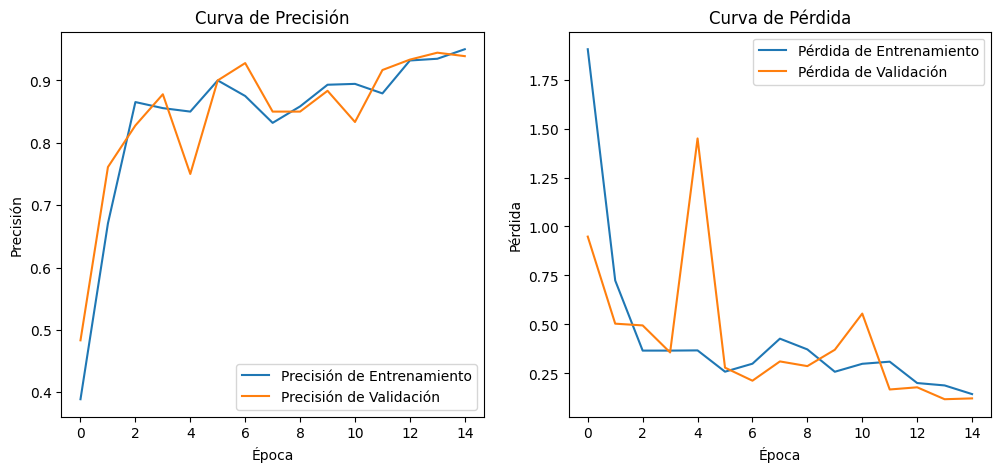


Evaluando el modelo con los datos de prueba...
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.9709 - loss: 0.1023

 Precisión final en el conjunto de prueba: 97.00%


In [ ]:
# --- Gráficas de Precisión y Pérdida durante el entrenamiento ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Precisión de Entrenamiento')
plt.plot(range(EPOCHS), val_acc, label='Precisión de Validación')
plt.legend(loc='lower right')
plt.title('Curva de Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Pérdida de Entrenamiento')
plt.plot(range(EPOCHS), val_loss, label='Pérdida de Validación')
plt.legend(loc='upper right')
plt.title('Curva de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

# --- Evaluación final con el conjunto de prueba ---
print("\nEvaluando el modelo con los datos de prueba...")
test_loss, test_acc = model_complejo.evaluate(test_dataset)
print(f"\n Precisión final en el conjunto de prueba: {test_acc*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


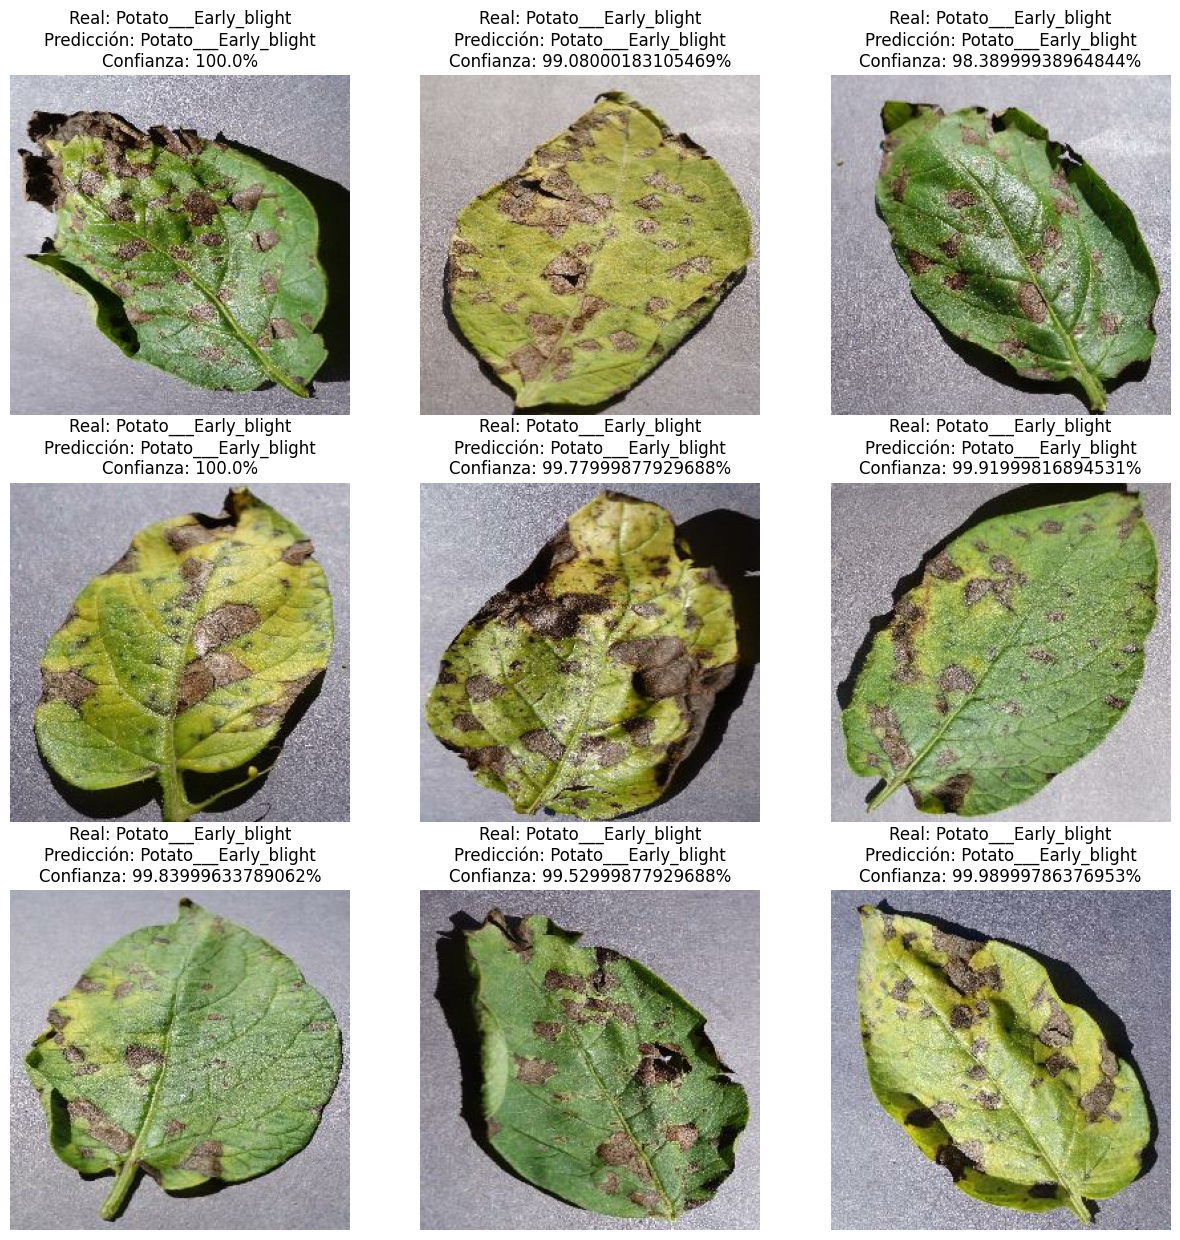

In [ ]:
import numpy as np

# --- Función para predecir una sola imagen ---
def predict_image(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Crear un lote de una sola imagen

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# --- Visualizar predicciones en un conjunto de imágenes de prueba ---
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):  # Mostramos las primeras 9 imágenes
        ax = plt.subplot(3, 3, i + 1)
        # Unnormalize images before displaying
        plt.imshow((images[i].numpy() * 255).astype("uint8"))

        predicted_class, confidence = predict_image(model_complejo, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Real: {actual_class}\nPredicción: {predicted_class}\nConfianza: {confidence}%")
        plt.axis("off")